In [ ]:
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import product
import random
from tqdm import trange

In [295]:
# Set random seed for full reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Data Loading & Preparation

- **Load** time series from `.mat` file (`Xtrain`)
- **Normalize** values to [0, 1] using `MinMaxScaler` (for stable NN training)
- **Create supervised dataset** for time series forecasting:
  - Convert 1D time series → pairs of:
    - `X`: past `n_steps` values (input window)
    - `y`: next immediate value (target)
  - Example:  
    - Input `[x₀, x₁, ..., xₙ₋₁]` → Target `xₙ`
  - Enables model to learn to predict the next time step from recent history


In [ ]:
# Load data
mat = scipy.io.loadmat('Xtrain.mat')
data = mat['Xtrain'].flatten().reshape(-1, 1) 

# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# Create window sequences
def create_dataset(series, n_steps):
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i + n_steps].flatten())
        y.append(series[i + n_steps])
    return np.array(X), np.array(y)

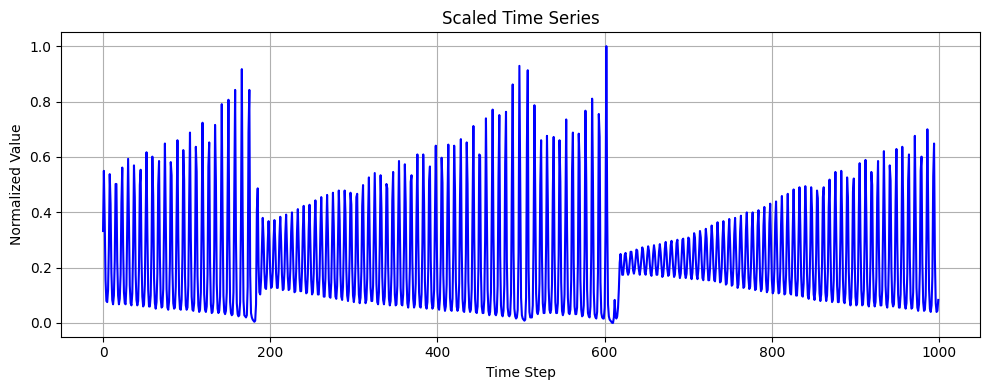

In [297]:
# Plot the scaled data
plt.figure(figsize=(10, 4))
plt.plot(scaled, color='blue')
plt.title('Scaled Time Series')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### **Model**

#### Feedforward Neural Network (FFNN)

* **Purpose**:
  Predict the next time step value based on the previous `n_steps` input values — a typical regression task for time series forecasting.

* **Architecture**:

  * **Input layer**: Accepts a vector of size `input_size` (equal to `n_steps`)
  * **Two hidden layers**:

    * **Hidden Layer 1**: Fully connected (`Linear`) with `hidden_sizes[0]` neurons, followed by ReLU activation and a dropout layer.
    * **Hidden Layer 2**: Fully connected with `hidden_sizes[1]` neurons, also followed by ReLU and dropout.
  * **Output layer**: A single neuron (`Linear`) to produce the predicted value (suitable for regression).

* **Dropout Regularization**:

  * Dropout layers (with rate `dropout_rate`, e.g., 0.2) are inserted after each ReLU activation in the hidden layers.
  * **Purpose**: Helps prevent overfitting by randomly dropping a fraction of the neurons during training.

* **Implementation**:

  * The entire model is defined using `nn.Sequential` for a clean and modular structure.
  * A `forward` method simply passes input `x` through the network pipeline defined in `self.net`.

In [298]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[1], 1)
        )

    def forward(self, x):
        return self.net(x)

### **Training Function: `train_model(...)`**

#### **Purpose**:

Train a PyTorch model using the training set and evaluate it on the validation set, with **early stopping** to prevent overfitting.


### **Key Components & What They Do**

#### **Parameters**:

* `model`: the neural network to be trained
* `criterion`: loss function (e.g., `nn.MSELoss()`)
* `optimizer`: optimization algorithm (e.g., Adam)
* `X_train_tensor`, `y_train_tensor`: training data (features and targets)
* `X_val_tensor`, `y_val_tensor`: validation data
* `max_epochs`: max number of training epochs (default: 150)
* `patience`: how many epochs to wait for improvement before stopping early (default: 5)
* `min_delta`: minimum improvement in validation loss to be considered significant (default: 1e-4)

### **Training Loop (Epoch-wise)**

For each epoch:

1. **Training Phase**:

   * Set model to training mode (`model.train()`)
   * Zero the gradients
   * Forward pass: predict on training data
   * Compute loss
   * Backward pass: compute gradients
   * Update model weights via optimizer

2. **Validation Phase**:

   * Set model to evaluation mode (`model.eval()`)
   * Turn off gradients with `torch.no_grad()` for faster inference
   * Compute validation predictions and loss

3. **Early Stopping Logic**:

   * If validation loss improves (by at least `min_delta`), save:

     * `best_state`: model's parameters (weights)
     * `best_train`, `best_val`: loss curves
     * Reset counter for `epochs_no_improve`
   * Else, increase `epochs_no_improve` by 1
   * If no improvement for `patience` epochs, **stop training early**

### **Returns**:

* `best_loss`: lowest validation loss achieved
* `best_state`: the model weights at the best epoch
* `best_train`: list of training losses per epoch (up to early stop)
* `best_val`: list of validation losses per epoch (up to early stop)




In [299]:
# --- Training Function ---
def train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
                max_epochs=150, patience=5, min_delta=1e-4):
    best_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred, y_val_tensor)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if val_loss.item() < best_loss - min_delta:
            best_loss = val_loss.item()
            best_state = model.state_dict()
            best_train = train_losses.copy()
            best_val = val_losses.copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    return best_loss, best_state, best_train, best_val

### **Hyperparameter Grid Search with Early Stopping**

#### **Purpose**:

Systematically search over combinations of model hyperparameters to find the configuration that gives the **lowest validation loss**. For each combination, the model is trained and evaluated.

### **Grid Definition**

These lists define the combinations you’ll test:

* `n_steps_list`: how many past time steps are used as input
* `lrs`: different learning rates for the optimizer
* `hidden_size_sets`: tuples of hidden layer sizes (2 layers)
* `dropout_rates`: dropout probability applied during training

All possible combinations are tried using `itertools.product(...)`.


### **Inside the Loop – For Each Combination**

1. **Data Preparation**:

   * `create_dataset(...)` builds the input (`X`) and target (`y`) pairs using a sliding window of `n_steps`.
   * `train_test_split(...)` randomly splits data into training (80%) and validation (20%) sets, with reproducibility via `random_state=SEED`.

2. **Tensor Conversion**:

   * Converts NumPy arrays to PyTorch tensors, which are needed to train the model.

3. **Model Setup**:

   * Creates a new `FeedForwardNN` instance using the current `n_steps`, `hidden_sizes`, and `drop_out`.
   * Defines the loss function (`MSELoss`) and optimizer (Adam with current `lr`).

4. **Training**:

   * Calls `train_model(...)`, which trains the model using early stopping and returns:

     * `val_loss`: the best validation loss achieved
     * `state`: the model weights at that point
     * `train_loss_curve` and `val_loss_curve`: loss values per epoch

5. **Results Tracking**:

   * Appends the configuration and its validation loss to `all_results` for later comparison or visualization.

6. **Best Model Tracking**:

   * If this config achieves a **lower validation loss** than previous ones, store:

     * `best_val_loss`: the new lowest loss
     * `best_config`: the corresponding hyperparameters
     * `best_model_state`: the best-performing weights
     * `best_X_train`, `best_X_val`, `best_y_train`, `best_y_val`: corresponding datasets
     * `best_train_losses`, `best_val_losses`: for plotting or analysis

In [300]:
n_steps_list = [40, 50, 60, 70]
lrs = [0.005, 0.001 , 0.0005]
hidden_size_sets = [(64, 32), (128, 64)]
dropout_rates = [0.0, 0.1, 0.2]


best_val_loss = float('inf')
best_config = None
best_model_state = None
best_train_losses = []
best_val_losses = []

best_X_train = None
best_X_val = None
best_y_train = None
best_y_val = None

all_results = []

for n_steps, lr, hidden_sizes, drop_out in product(n_steps_list, lrs, hidden_size_sets, dropout_rates):
    print(f"\nTraining with n_steps={n_steps}, lr={lr}, hidden_sizes={hidden_sizes}")

    # Prepare data
    X, y = create_dataset(scaled, n_steps)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=SEED)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Init model, loss, optimizer
    model = FeedForwardNN(n_steps, hidden_sizes, drop_out)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train model
    val_loss, state, train_loss_curve, val_loss_curve = train_model(
        model, criterion, optimizer,
        X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor
    )

    # Store result of this config
    all_results.append({
        'n_steps': n_steps,
        'lr': lr,
        'hidden_sizes': hidden_sizes,
        'drop_out': drop_out,
        'val_loss': val_loss
    })

    # Save best configuration and corresponding data
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_config = (n_steps, lr, hidden_sizes, drop_out)
        best_model_state = state
        best_train_losses = train_loss_curve
        best_val_losses = val_loss_curve
        best_X_train = X_train
        best_X_val = X_val
        best_y_train = y_train
        best_y_val = y_val


Training with n_steps=40, lr=0.005, hidden_sizes=(64, 32)

Training with n_steps=40, lr=0.005, hidden_sizes=(64, 32)

Training with n_steps=40, lr=0.005, hidden_sizes=(64, 32)

Training with n_steps=40, lr=0.005, hidden_sizes=(128, 64)

Training with n_steps=40, lr=0.005, hidden_sizes=(128, 64)

Training with n_steps=40, lr=0.005, hidden_sizes=(128, 64)

Training with n_steps=40, lr=0.001, hidden_sizes=(64, 32)

Training with n_steps=40, lr=0.001, hidden_sizes=(64, 32)

Training with n_steps=40, lr=0.001, hidden_sizes=(64, 32)

Training with n_steps=40, lr=0.001, hidden_sizes=(128, 64)

Training with n_steps=40, lr=0.001, hidden_sizes=(128, 64)

Training with n_steps=40, lr=0.001, hidden_sizes=(128, 64)

Training with n_steps=40, lr=0.0005, hidden_sizes=(64, 32)

Training with n_steps=40, lr=0.0005, hidden_sizes=(64, 32)

Training with n_steps=40, lr=0.0005, hidden_sizes=(64, 32)

Training with n_steps=40, lr=0.0005, hidden_sizes=(128, 64)

Training with n_steps=40, lr=0.0005, hidden_

In [301]:
# ---- Final result ----
print("\nBest Model Found:")
print(f"n_steps={best_config[0]}, lr={best_config[1]}, hidden_sizes={best_config[2]}, drop_out={best_config[3]}")
print(f"Validation Loss: {best_val_loss:.6f}")

# Load best model
best_model = FeedForwardNN(best_config[0], best_config[2], best_config[3])
best_model.load_state_dict(best_model_state)
best_model.eval()


Best Model Found:
n_steps=60, lr=0.005, hidden_sizes=(128, 64), drop_out=0.0
Validation Loss: 0.001166


FeedForwardNN(
  (net): Sequential(
    (0): Linear(in_features=60, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [302]:
df_results = pd.DataFrame(all_results)
df_results['params'] = df_results.apply(
    lambda row: f"n={row['n_steps']}, lr={row['lr']}, h={row['hidden_sizes']}, drop={row['drop_out']}", axis=1
)

# Print sorted results
print("\nAll Config Results (sorted):")
print(df_results.sort_values("val_loss"))


All Config Results (sorted):
    n_steps      lr hidden_sizes  drop_out  val_loss  \
39       60  0.0050    (128, 64)       0.0  0.001166   
46       60  0.0010    (128, 64)       0.1  0.001171   
40       60  0.0050    (128, 64)       0.1  0.001233   
41       60  0.0050    (128, 64)       0.2  0.001237   
36       60  0.0050     (64, 32)       0.0  0.001248   
..      ...     ...          ...       ...       ...   
44       60  0.0010     (64, 32)       0.2  0.030310   
51       60  0.0005    (128, 64)       0.0  0.033312   
27       50  0.0010    (128, 64)       0.0  0.033800   
61       70  0.0010     (64, 32)       0.1  0.034650   
62       70  0.0010     (64, 32)       0.2  0.042472   

                                    params  
39   n=60, lr=0.005, h=(128, 64), drop=0.0  
46   n=60, lr=0.001, h=(128, 64), drop=0.1  
40   n=60, lr=0.005, h=(128, 64), drop=0.1  
41   n=60, lr=0.005, h=(128, 64), drop=0.2  
36    n=60, lr=0.005, h=(64, 32), drop=0.0  
..                         

### **Plot 1: Best Model Loss Evolution Through Epochs**

```python
def plot_best_model_loss(train_losses, val_losses):
```

#### **Purpose**:

Visualize how the **training and validation loss evolved** during training of the **best model** (the one with the lowest validation loss across all configs).

#### **What It Shows**:

* X-axis: Epochs
* Y-axis: Loss (Mean Squared Error)
* Two curves:

  * **Train Loss**: how well the model fits training data
  * **Validation Loss**: how well it generalizes to unseen data

#### **Why It's Useful**:

* Shows if the model is **overfitting** (validation loss increases while train loss keeps dropping)
* Confirms if **early stopping** was triggered (plot flattens early)
* Helps understand model training behavior visually

In [ ]:
# Plot 1: Best Model Loss Evolution Through Epochs
def plot_best_model_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Best Model Loss Evolution Through Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()    

In [ ]:
plot_best_model_loss(best_train_losses, best_val_losses)

### **Plot 2: Bar Plot of Validation Loss vs `n_steps` for Best Hyperparameter Settings**

```python
def bar_plot_val_loss_vs_n_steps_best_config(all_results):
```

#### **Purpose**:

Compare the **effect of different `n_steps` values** (i.e., how much past context the model uses) on validation performance, **while keeping all other hyperparameters fixed** at their best values.

#### **How It Works**:

1. Converts `all_results` (a list of dictionaries) into a DataFrame.
2. Finds the configuration with the **lowest validation loss** overall.
3. Filters the DataFrame to only include rows with:

   * Same learning rate, hidden sizes, and dropout as the best config
4. Plots validation loss for each `n_steps` in this filtered group.

#### **What It Shows**:

* X-axis: `n_steps` (converted to string for categorical bar labels)
* Y-axis: Corresponding validation loss
* Annotated bars show exact loss values

#### **Why It's Useful**:

* Shows how the **amount of past time steps** (`n_steps`) influences model performance.
* Helps pick the optimal `n_steps` for your forecasting task.

In [ ]:
#Plot 2: Bar Plot of Validation Loss vs n_steps for Best Config
def bar_plot_val_loss_vs_n_steps_best_config(all_results):
    df = pd.DataFrame(all_results)

    # Find the best overall config (lowest validation loss)
    best_row = df.loc[df['val_loss'].idxmin()]
    best_lr = best_row['lr']
    best_hidden = best_row['hidden_sizes']
    best_drop = best_row['drop_out']

    # Filter to only rows with best lr and hidden sizes
    filtered_df = df[(df['lr'] == best_lr) & (df['hidden_sizes'] == best_hidden) & (df['drop_out'] == best_drop)]
    filtered_df = filtered_df.sort_values(by='n_steps')

    # Plot
    plt.figure(figsize=(10, 5))
    bars = plt.bar(filtered_df['n_steps'].astype(str), filtered_df['val_loss'])
    plt.xlabel('n_steps')
    plt.ylabel('Validation Loss')
    plt.title(f'Validation Loss by n_steps (best config: lr={best_lr}, h={best_hidden}, drop={best_drop})')
    plt.grid(axis='y')

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', 
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

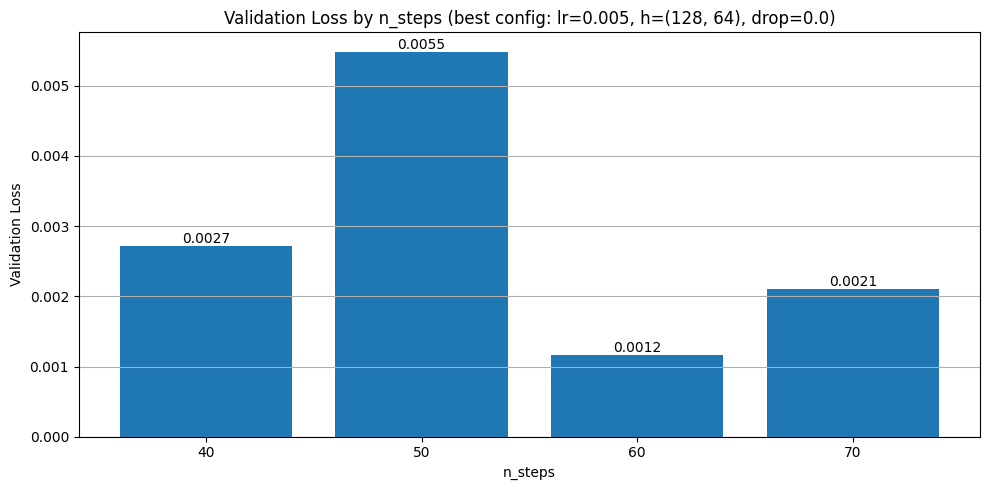

In [304]:
# Call after your search
bar_plot_val_loss_vs_n_steps_best_config(all_results)

### **Validation Forecasting & Visualization**

#### **Forecasting Process**

* **Set model to eval mode** → Ensures stable inference (e.g., no dropout)
* **Generate predictions** → Run the model on validation input data
* **Inverse transform**:

  * **Predictions**: Convert from normalized to original scale
  * **True values**: Do the same for validation targets
* **Return**: Rescaled predictions and true values (for comparison)


### **Purpose**

* Evaluate how accurately the model generalizes to unseen data
* Visual check to complement numeric loss values
* Identify underfitting, overfitting, or bias visually


### **Plot: Predictions vs True Values**

* **X-axis**: Time steps (validation set index)
* **Y-axis**: Actual vs predicted values (original scale)
* **Lines**:

  * 🔵 Blue: Ground truth (actual validation values)
  * 🔴 Red dashed: Model predictions
* **Goal**: See how well red tracks blue — closer = better performance

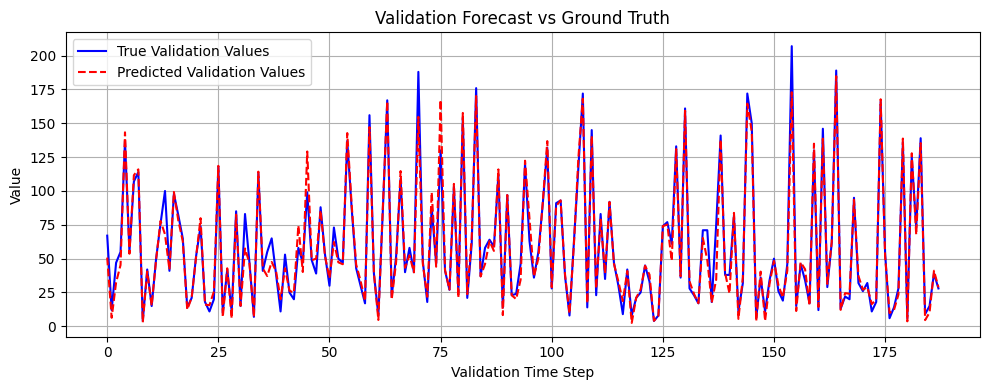

In [306]:
def forecast_validation(model, X_val, y_val, scaler):
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        preds = model(X_val_tensor).numpy()

    # Inverse scale predictions and actual values
    preds_rescaled = scaler.inverse_transform(preds)
    y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))
    return preds_rescaled.flatten(), y_val_rescaled.flatten()


# Forecast on validation set
val_predictions, val_true = forecast_validation(best_model, best_X_val, best_y_val, scaler)

# Plot predictions vs true values
plt.figure(figsize=(10, 4))
plt.plot(val_true, label='True Validation Values', color='blue')
plt.plot(val_predictions, label='Predicted Validation Values', color='red', linestyle='--')
plt.title('Validation Forecast vs Ground Truth')
plt.xlabel('Validation Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### **🔁 Recursive Forecasting**

#### **Purpose**:

Generate **future predictions beyond your existing dataset** by feeding the model's own previous predictions back as input.


### **Process Breakdown**

* **Model in eval mode** → Ensures consistent behavior for inference

* **Start with `seed_seq`** → This is the last known input sequence (e.g., last `n_steps` values)

* **For each future time step**:

  * Use the current input sequence to **predict the next value**
  * **Append the prediction** to the forecast list
  * **Update the input sequence**:

    * Remove the oldest value
    * Add the new prediction to the end
    * This simulates moving forward in time

* **Inverse transform the predictions** → Convert them back to the original scale using the scaler


### **Output**

* A 1D array of `n_future` predicted values, scaled back to real-world units


### **Why It’s Important**

* Enables **multi-step ahead forecasting** when only a single-step model is trained
* Simulates realistic deployment where true future values aren’t available
* Useful for planning, anomaly detection, or proactive decisions

In [307]:
# ----  Recursive Forecasting Function ----

def recursive_forecast(model, seed_seq, n_future, scaler):
    model.eval()
    forecast = []
    input_seq = seed_seq.copy()

    for _ in range(n_future):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).view(1, -1)
        with torch.no_grad():
            next_val = model(input_tensor).item()
        forecast.append(next_val)
        input_seq = input_seq[1:] + [next_val]  # Slide the window

    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast.flatten()

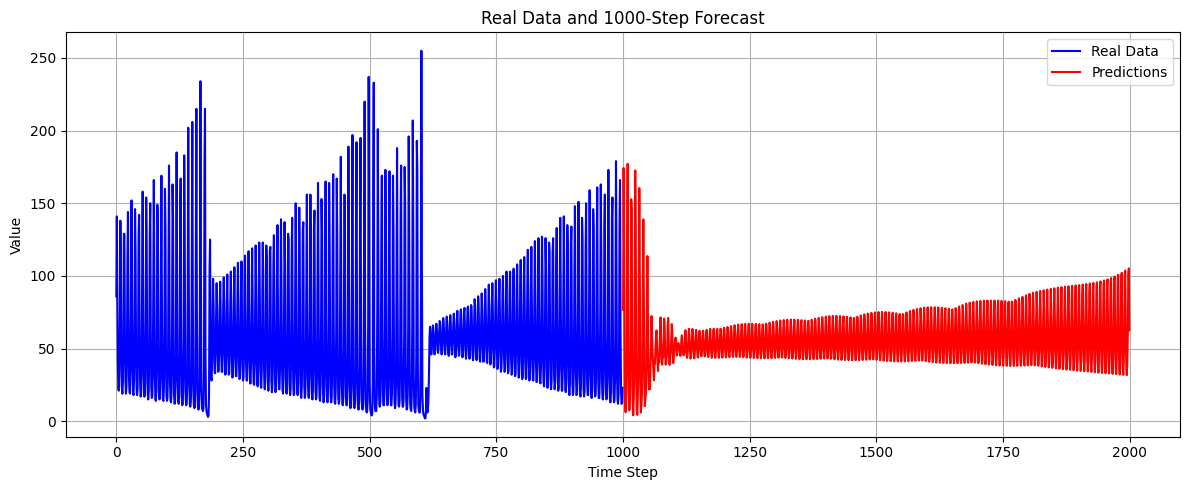

In [ ]:
# Use the last real window as seed
last_window = scaled[-best_n_steps:].flatten().tolist()
best_n_steps = best_config[0] # Number of window size used in the best model
n_future = 1000  # Number of future steps to predict
future_preds = recursive_forecast(best_model, last_window, n_future=1000, scaler=scaler)

# Inverse transform the full scaled dataset back to original scale for plotting
real_data = scaler.inverse_transform(scaled)

# Create an array combining the original data with predictions
extended = np.concatenate((real_data.flatten(), future_preds))

# Create time axis
time_axis = np.arange(len(extended))
real_axis = np.arange(len(real_data))
pred_axis = np.arange(len(real_data), len(extended))

# Plot
plt.figure(figsize=(12, 5))
#plt.plot(time_axis, extended, label='Extended (Real + Predicted)', linestyle='--', color='gray')
plt.plot(real_axis, real_data, label='Real Data', color='blue')
plt.plot(pred_axis, future_preds, label='Predictions', color='red')
plt.title(f'Real Data and {n_future}-Step Forecast')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()